In [152]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()

,Period,Sessions,Cluster
0,2011-07-29 20:00:00,1,HAMILTON
1,2011-07-29 20:30:00,1,HAMILTON
2,2011-07-29 21:00:00,1,HAMILTON
3,2011-07-29 21:30:00,1,HAMILTON
4,2011-07-29 22:00:00,1,HAMILTON


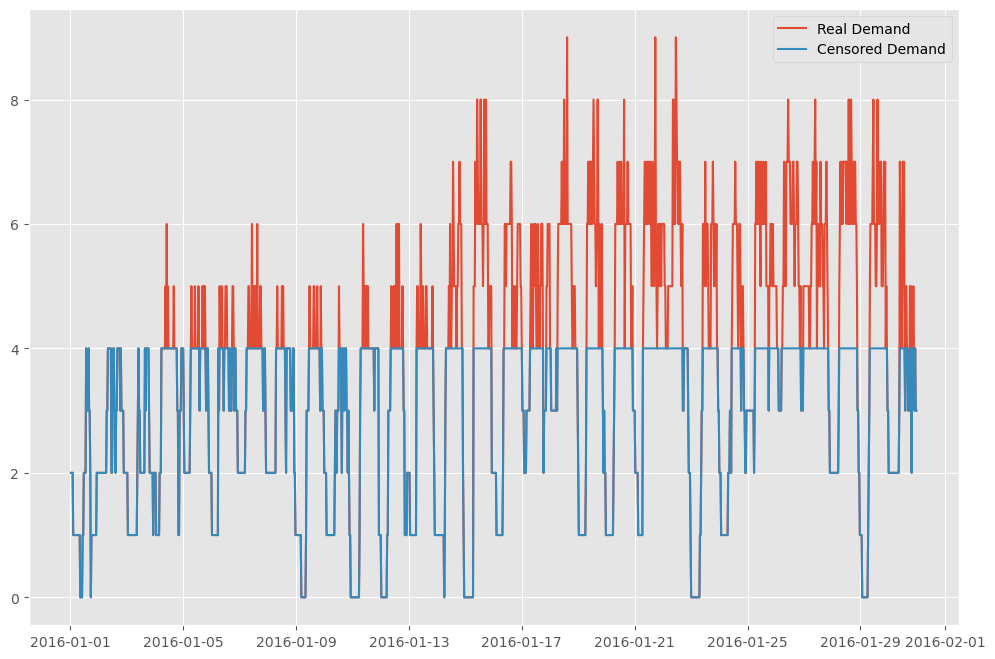

In [153]:

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))

df_sample = df[(df.Cluster == 'WEBSTER') & ((df.Period > '2016-01-01') & (df.Period < '2016-01-31'))].copy()
df_sample['Censored'] = df_sample['Sessions'].values

df_sample.loc[df_sample.Sessions > 4, 'Censored'] = 4

plt.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand')
plt.plot(df_sample.Period, df_sample.Censored.values, label='Censored Demand')
plt.legend()
plt.show()

In [154]:
import torch.nn as nn
import torch
import numpy as np

In [155]:
class AR_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(AR_Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim, output_dim) 
        # Linear function (readout)

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.relu(out)
        return out
    
class AR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AR, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim) 
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        return out

In [156]:
input_dim = 48*7
output_dim = 48
hidden_dim = 100

X_train = df_sample.reset_index(drop=True).iloc[:input_dim]
y_train = df_sample.reset_index(drop=True).iloc[input_dim:input_dim+output_dim]

model = AR(input_dim, output_dim)

In [157]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    return loss.data.item()


In [183]:
def poisson_negative_log_likelihood(y_predict, y):
    """ https://en.wikipedia.org/wiki/Poisson_regression#Maximum_likelihood-based_parameter_estimation """
    return -torch.mean(y*y_predict - torch.exp(y_predict))

Epoch: 0 Loss: -0.6832135319709778
Epoch: 1 Loss: 0.8087913990020752
Epoch: 2 Loss: -0.596718966960907
Epoch: 3 Loss: -0.41167977452278137
Epoch: 4 Loss: -0.05366965010762215
Epoch: 5 Loss: -0.04195289686322212
Epoch: 6 Loss: -0.11416876316070557
Epoch: 7 Loss: -0.23319685459136963
Epoch: 8 Loss: -0.41461244225502014
Epoch: 9 Loss: -0.5816087126731873
Epoch: 10 Loss: -0.6148970127105713
Epoch: 11 Loss: -0.4938500225543976
Epoch: 12 Loss: -0.3773047924041748
Epoch: 13 Loss: -0.4105184078216553
Epoch: 14 Loss: -0.5522563457489014
Epoch: 15 Loss: -0.662493884563446
Epoch: 16 Loss: -0.6646811962127686
Epoch: 17 Loss: -0.5924651622772217
Epoch: 18 Loss: -0.5238408446311951
Epoch: 19 Loss: -0.5112901329994202
Epoch: 20 Loss: -0.5577828288078308
Epoch: 21 Loss: -0.6272826790809631
Epoch: 22 Loss: -0.6720172762870789
Epoch: 23 Loss: -0.6672421097755432
Epoch: 24 Loss: -0.6315026879310608
Epoch: 25 Loss: -0.6059584617614746
Epoch: 26 Loss: -0.6132822632789612
Epoch: 27 Loss: -0.6417117118835449

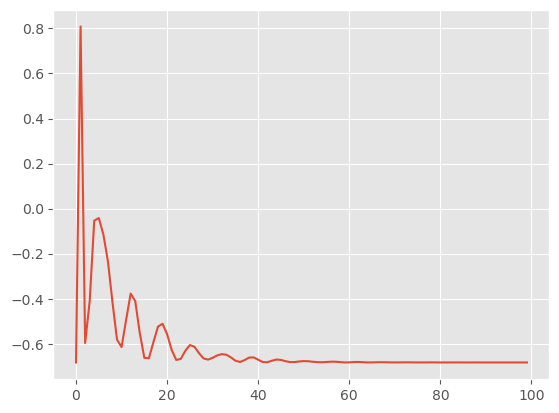

In [184]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = poisson_negative_log_likelihood
losses = []
for epoch in range(epochs):
    x = torch.tensor(X_train.Sessions.values, dtype=torch.float32).view(1, -1)
    y = torch.tensor(y_train.Sessions.values, dtype=torch.float32).view(1, -1)
    loss = train_batch(model, x, y, optimizer, loss_fn)
    losses.append(loss)
    print(f'Epoch: {epoch} Loss: {loss}')
plt.plot(losses)

In [185]:
# make prediction
y_predict = model.forward(x)
y_predict = y_predict.detach().numpy().reshape(-1)

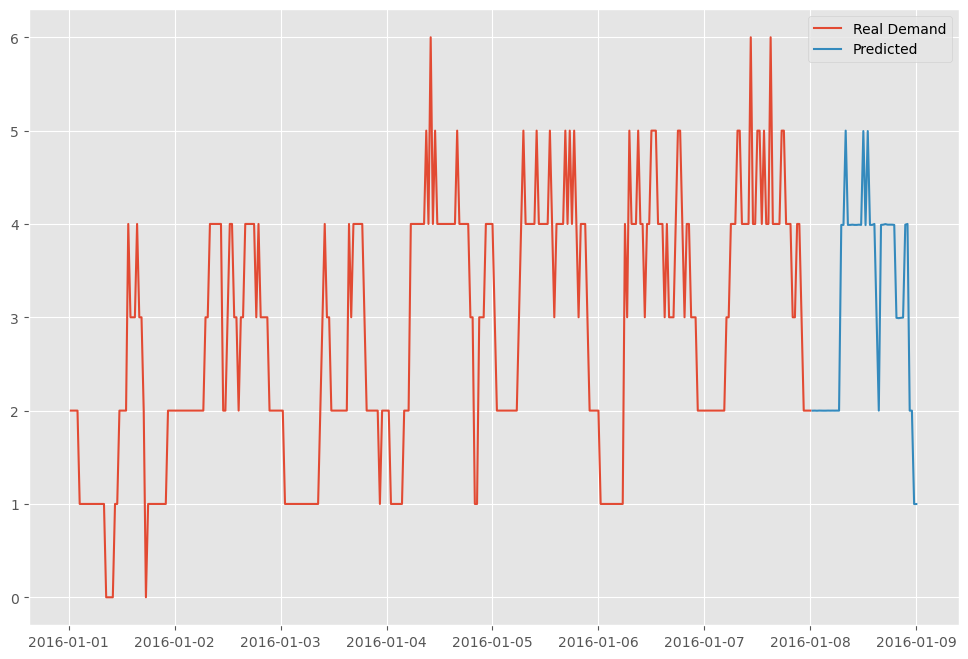

In [186]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(X_train.Period, X_train.Sessions.values, label='Real Demand')
plt.plot(y_train.Period, np.exp(y_predict), label='Predicted')
plt.legend()